In [1]:
import numpy as np
import matplotlib.pyplot as plt

Define the mesh

In [2]:
n = 100
h = 1.0/n
xL = np.linspace(0, 1-h, num=n)
xR = np.linspace(h, 1, num=n)
xC = 0.5*(xL + xR)

Initial conditions

In [3]:
p0 = np.exp(-100*(xC - 0.35)**2)
u0 = 0*xC
q0 = np.stack((p0, u0))

Problem setup

In [4]:
K = 2.0
rho = 0.25

c = np.sqrt(K/rho)

Plotting

In [5]:
def plot_q(x, q):
   fig, axis = plt.subplots(2)
   fig.tight_layout(pad=2.0)
   axis[0].plot(x, q[0,:])
   axis[0].set_title("Pressure ($p$)")
   axis[1].plot(x, q[1,:])
   axis[1].set_title("Velocity ($u$)")

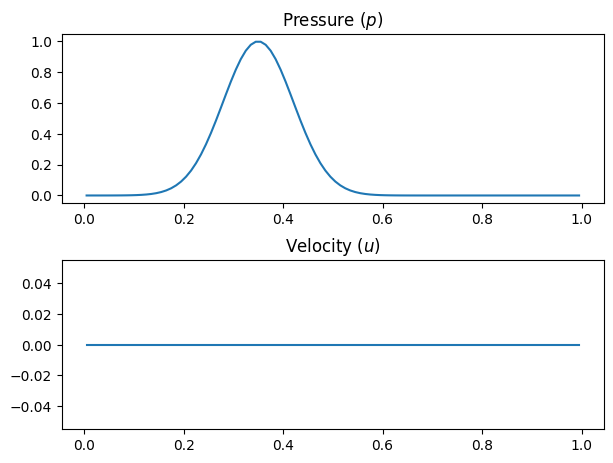

In [6]:
plot_q(xC, q0)

### Godunov's method



Time-step restriction (CFL condition)

In [7]:
T = 0.25
dt = h/c

nt = int(np.ceil(T/dt))

In [8]:
def flux(q):
   return np.array([K*q[1], (1/rho)*q[0]])

def solve_riemann(qL, qR):
   r1 = np.array([np.sqrt(K*rho), 1])
   r2 = np.array([-np.sqrt(K*rho), 1])
   R = np.array([r1, r2]).T
   wL = np.linalg.solve(R, qL)
   wR = np.linalg.solve(R, qR)
   q_star = wL[0]*r1 + wR[1]*r2
   return flux(q_star)

In [9]:
def compute_flux(q):
   F = np.zeros((2,n+1))
   for i in range(n+1):
      if i > 0:
         qL = q[:,i-1]
      else:
         # reflection BC
         r1 = np.array([np.sqrt(K*rho), 1])
         r2 = np.array([-np.sqrt(K*rho), 1])
         R = np.array([r1, r2]).T
         w = np.linalg.solve(R, q[:,0])
         qL = -w[1]*r1 + w[1]*r2

      if i < n:
         qR = q[:,i]
      else:
         # reflection BC
         r1 = np.array([np.sqrt(K*rho), 1])
         r2 = np.array([-np.sqrt(K*rho), 1])
         R = np.array([r1, r2]).T
         w = np.linalg.solve(R, q[:,-1])
         qR = w[0]*r1 - w[0]*r2

      F[:,i] = solve_riemann(qL, qR)
   return F

In [10]:
qs = np.zeros((2, n, nt+1))
qs[:,:,0] = q0
for i in range(nt):
   F = compute_flux(qs[:,:,i])
   qs[:,:,i+1] = qs[:,:,i] - dt/h*np.diff(F)

In [11]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

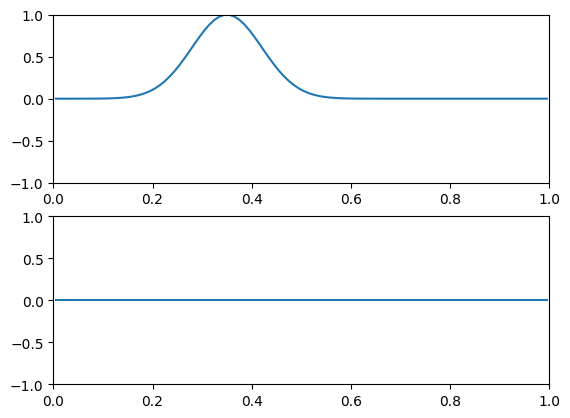

In [12]:
fig, axis = plt.subplots(2)
line_0, = axis[0].plot([])
line_1, = axis[1].plot([])
axis[0].set_xlim(0, 1)
axis[1].set_xlim(0, 1)
axis[0].set_ylim(-1, 1)
axis[1].set_ylim(-1, 1)

def set_data(i):
   line_0.set_data((xC, qs[0,:,i]))
   line_1.set_data((xC, qs[1,:,i]))

anim = FuncAnimation(fig, set_data, frames=nt)
HTML(anim.to_jshtml())

In [13]:
def plot_w(x, q):
   w = 0*q

   r1 = np.array([np.sqrt(K*rho), 1])
   r2 = np.array([-np.sqrt(K*rho), 1])
   R = np.array([r1, r2]).T
   for i in range(n):
      w[:,i] = np.linalg.solve(R, q[:,i])

   fig, axis = plt.subplots(2)
   fig.tight_layout(pad=2.0)
   axis[0].plot(x, w[0,:])
   axis[0].set_title("$w_1$")
   axis[1].plot(x, w[1,:])
   axis[1].set_title("$w_2$")

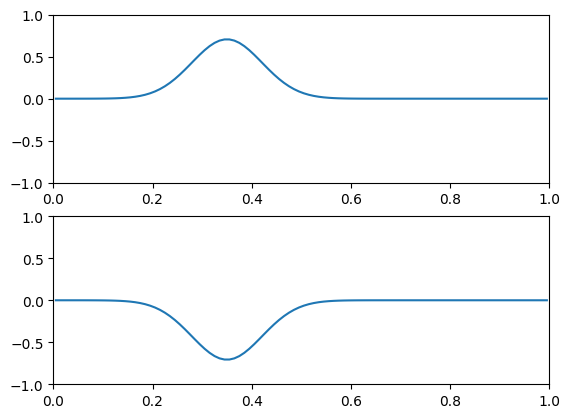

In [14]:
fig, axis = plt.subplots(2)
line_0, = axis[0].plot([])
line_1, = axis[1].plot([])
axis[0].set_xlim(0, 1)
axis[1].set_xlim(0, 1)
axis[0].set_ylim(-1, 1)
axis[1].set_ylim(-1, 1)

r1 = np.array([np.sqrt(K*rho), 1])
r2 = np.array([-np.sqrt(K*rho), 1])
R = np.array([r1, r2]).T

def set_data(i):
   w = 0*qs[:,:,i]
   for j in range(n):
      w[:,j] = np.linalg.solve(R, qs[:,j,i])
   line_0.set_data((xC, w[0,:]))
   line_1.set_data((xC, w[1,:]))

anim = FuncAnimation(fig, set_data, frames=nt)
HTML(anim.to_jshtml())